## CNN With Best Hyperparameters
We train a fully connected CNN with the best hyperparameters obtained from PSO_CNN notebook.

### Importing Necessary Libraries and loading our dataset
We will use Google Colab for this notebook, here we have imported necessary libraries and loaded our dataset from kaggle.

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ricedi:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4922976%2F8288094%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T090159Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ebe32fa22bb549ca463c6a03a5d07291c654c7bac8c7d75aae636675ef50501699974ee9a20c7ac92f03f81bdaa9f5febbd1f8711da3b96e2dc7637686ff4a608020c0323427c363a0d178ca702485899799aa510ebc25476c9ed3aa8eb16572ab3a5922bfa9b6940bea5a12e3aba39e45dbfba7dc9e1f8fb8128c8659b89d9b6c367060a9cc8c64f24f61b242a905775b38340aab11827e21f63847230b29b111204c6f02211f8f0e10b68a100d4303231dd23b0aef8caa25d7e439667b9d7c40b224d9fa8f21c66bdee50ab5d8e806e4038d77efefd47deb7e2290880e81d03da272854705e41f15147a4c8632033cbc384e65a0c4a48717a8edb12e3af60'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1063925948 bytes downloaded
Downloaded and uncompressed: ricedi
Data source import complete.


In [24]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os

In [25]:
BATCH_SIZE = 20
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/ricedi/Rice_Leaf_AUG/",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3829 files belonging to 6 classes.


### Data Partitions
This Python function, `get_dataset_partitions_tf`, partitions a given dataset (`ds`) into training, validation, and test sets using TensorFlow's `tf.data.Dataset` API. It takes arguments for the splits (`train_split`, `val_split`, `test_split`), shuffling options (`shuffle`, `shuffle_size`), and asserts that the splits sum to 1. It shuffles the dataset if specified, then calculates and returns the three dataset partitions.

In [27]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [28]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

### Checking our classes

In [29]:
class_names = dataset.class_names
class_names

['Bacterial Leaf Blight',
 'Brown Spot',
 'Healthy Rice Leaf',
 'Leaf Blast',
 'Leaf scald',
 'Sheath Blight']

### Visualizing our dataset

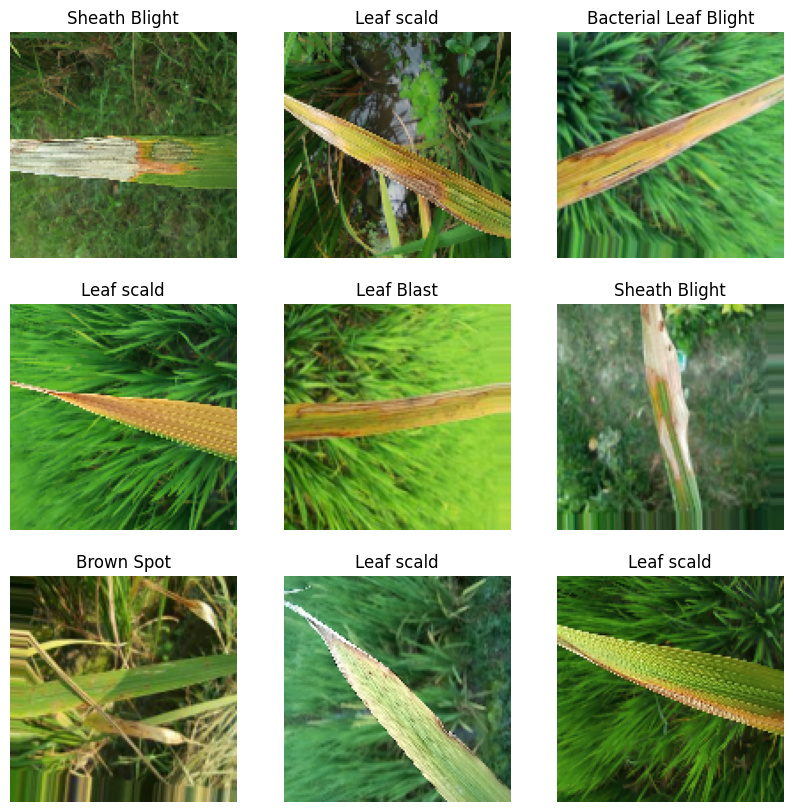

In [30]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### CNN with best Hyperparameters
This code defines a convolutional neural network (CNN) model using TensorFlow's Keras API and trains it on a dataset. Here's a breakdown of the code:

### 1. Model Definition:
- The `tf.keras.Sequential` function is used to create a sequential model, which is a linear stack of layers.
- The model begins with a `Rescaling` layer to scale input pixel values to the range [0, 1].
- It then has three convolutional layers each of these layers are set according to the parameters obtained from PSO-CNN (`Conv2D`) with ReLU activation functions, followed by max pooling (`MaxPooling2D`) layers to downsample the feature maps.
- After the convolutional layers, there's a `Flatten` layer to flatten the 3D output to 1D.
- The flattened output is passed through two dense (`Dense`) layers, the last one having 6 units for the classification of 6 classes.

### 2. Model Compilation:
- The `model.compile` method is used to configure the model for training.
- The Adam optimizer is used with the sparse categorical crossentropy loss function and accuracy as the metric.

### 3. Model Training:
- The `model.fit` method is used to train the model.
- It takes the training dataset (`train_ds`) and validation dataset (`val_ds`) as inputs, along with other parameters like verbosity (`verbose`), number of epochs (`epochs`), etc.
- The `fit` method trains the model for 20 epochs, optimizing the specified loss function using the specified optimizer.

Overall, this code defines a CNN model, compiles it, and trains it on a dataset for 20 epochs, using the Adam optimizer.


In [31]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(65, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(35, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(64, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(6)
    ]
)

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
153/153 [==============================] - 49s 153ms/step - loss: 1.5123 - accuracy: 0.3873 - val_loss: 1.1947 - val_accuracy: 0.5184
Epoch 2/20
153/153 [==============================] - 40s 142ms/step - loss: 1.0713 - accuracy: 0.5943 - val_loss: 0.9897 - val_accuracy: 0.6132
Epoch 3/20
153/153 [==============================] - 40s 138ms/step - loss: 0.9204 - accuracy: 0.6560 - val_loss: 0.8349 - val_accuracy: 0.6974
Epoch 4/20
153/153 [==============================] - 42s 142ms/step - loss: 0.8267 - accuracy: 0.6891 - val_loss: 0.6945 - val_accuracy: 0.7553
Epoch 5/20
153/153 [==============================] - 41s 145ms/step - loss: 0.6675 - accuracy: 0.7494 - val_loss: 0.6662 - val_accuracy: 0.7368
Epoch 6/20
153/153 [==============================] - 40s 137ms/step - loss: 0.5351 - accuracy: 0.8094 - val_loss: 0.5776 - val_accuracy: 0.7895
Epoch 7/20
153/153 [==============================] - 42s 150ms/step - loss: 0.4401 - accuracy: 0.8475 - val_loss: 0.3445 - val_ac

### Scores

In [34]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 19s 8ms/step - loss: 0.0301 - accuracy: 0.9900


### Model Summary

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 65)      1820      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 65)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 35)        20510     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 35)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)       

### Visualizing our Model Summary

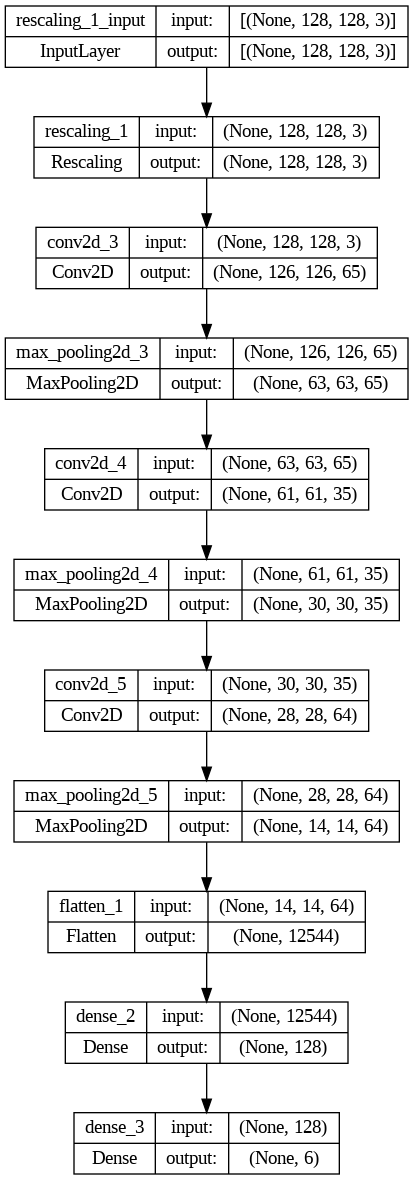

In [52]:
tf.keras.utils.plot_model(model, show_shapes=True)

This code is used to visualize the training and validation performance of a machine learning model, specifically a convolutional neural network (CNN) trained using TensorFlow's Keras API. Here's a breakdown of the code:

### 1. `history`:
- `history` is an object returned by the `model.fit` method when training the model. It contains information about the training process, such as loss and accuracy values for each epoch.

### 2. `history.params`:
- `history.params` is a dictionary containing the parameters used for training the model, such as batch size, number of epochs, etc.

### 3. `history.history.keys()`:
- `history.history.keys()` returns the keys of the `history.history` dictionary, which include 'accuracy', 'val_accuracy', 'loss', and 'val_loss'.

### 4. Data Extraction:
- `acc`, `val_acc`, `loss`, and `val_loss` are extracted from `history.history` and represent the training and validation accuracy and loss values for each epoch, respectively.

### 5. Visualization:
- Matplotlib is used to create a figure with two subplots.
- The first subplot (`plt.subplot(1, 2, 1)`) plots the training and validation accuracy (`acc` and `val_acc`) over the epochs.
- The second subplot (`plt.subplot(1, 2, 2)`) plots the training and validation loss (`loss` and `val_loss`) over the epochs.
- Both subplots have labels, legends, and titles to indicate what they represent.
- Finally, `plt.show()` is called to display the plots.

Overall, this code is a common practice in machine learning to visualize the training and validation performance of a model, which helps in understanding how well the model is learning the data and if there is any overfitting or underfitting.


In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 153}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

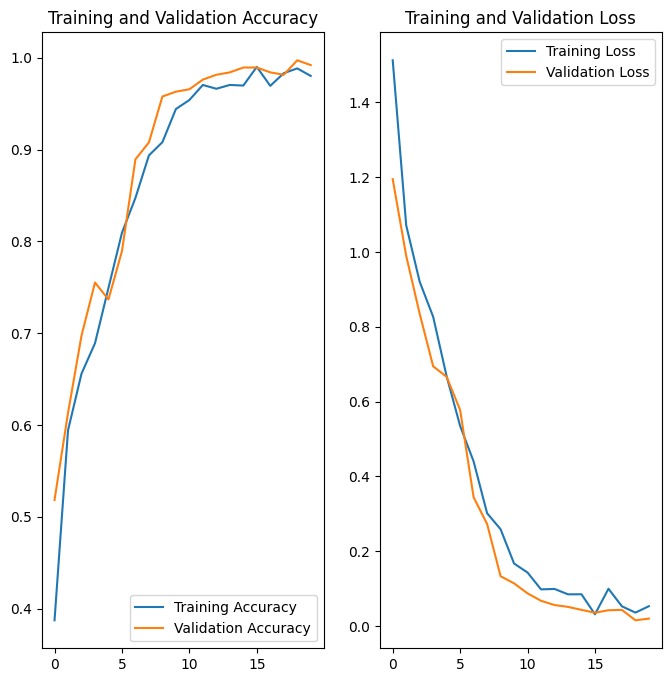

In [40]:
EPOCHS=20
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Visualizing our Results

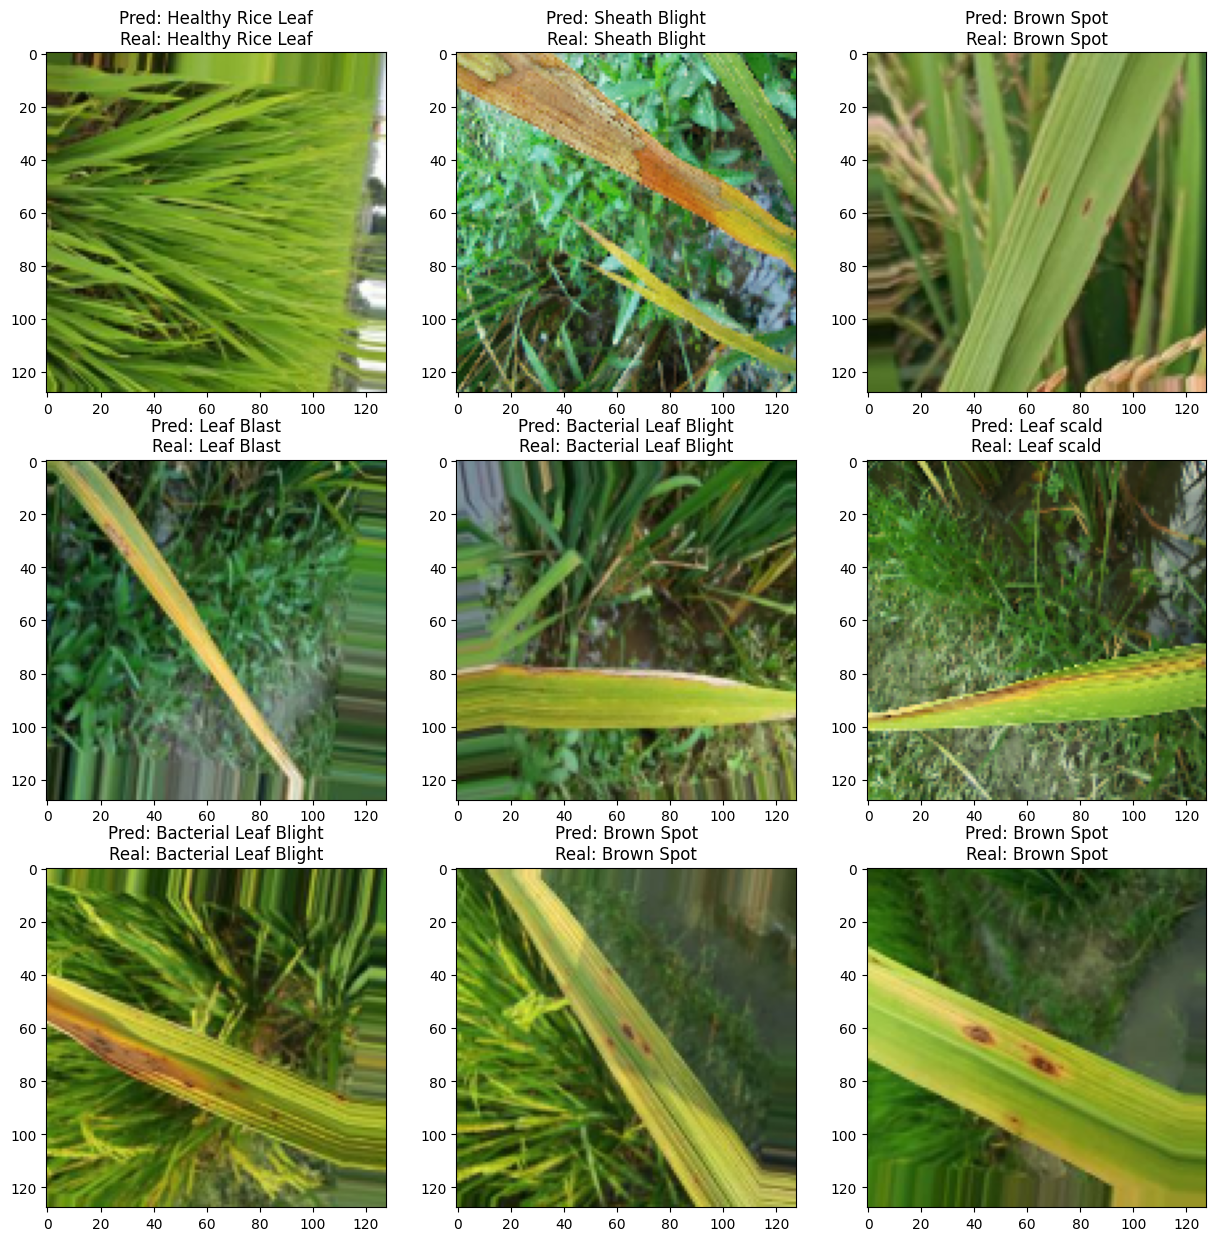

In [41]:
import numpy

plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    
  classifications = model(images)
  #print(classifications)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    #print(index)
    plt.title("Pred: " + class_names[index] + "\nReal: " + class_names[labels[i]])

### Confusion matrix

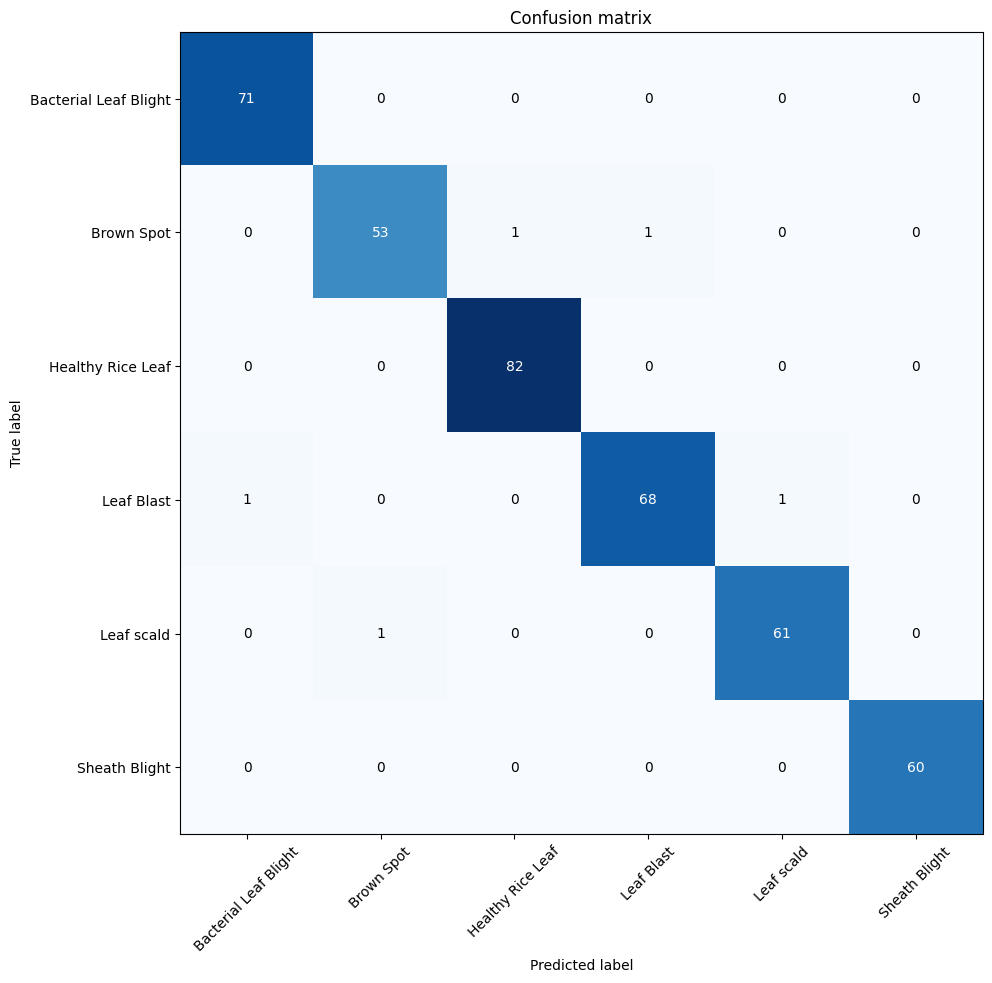

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming class_names is a list containing the class names
 # Fill this with your class names

# Collect predicted and actual labels
all_predicted_labels = []
all_actual_labels = []

for images, labels in test_ds:
    classifications = model(images)
    predicted_labels = [np.argmax(classification) for classification in classifications.numpy()]
    all_predicted_labels.extend(predicted_labels)
    all_actual_labels.extend(labels.numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_actual_labels, all_predicted_labels)

# Plot confusion matrix with numbers
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
#plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')


thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


### Classification Report

In [60]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_actual_labels, all_predicted_labels, target_names=class_names)

# Print classification report
print(report)

                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.99      1.00      0.99        71
           Brown Spot       0.98      0.96      0.97        55
    Healthy Rice Leaf       0.99      1.00      0.99        82
           Leaf Blast       0.99      0.97      0.98        70
           Leaf scald       0.98      0.98      0.98        62
        Sheath Blight       1.00      1.00      1.00        60

             accuracy                           0.99       400
            macro avg       0.99      0.99      0.99       400
         weighted avg       0.99      0.99      0.99       400



### Convert to TFLite Model

In [61]:
import tensorflow as tf
converter =  tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open("model.tflite" , "wb") .write(tfmodel)

6600436